In [ ]:
import torch
from dataset import MNIST
from clip import CLIP
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import multiprocessing

def main():
    DEVICE='cuda' if torch.cuda.is_available() else 'cpu'   # 设备

    dataset=MNIST() # 数据集

    model=CLIP().to(DEVICE) # 模型

    optimzer=torch.optim.Adam(model.parameters(),lr=1e-3)   # 优化器

    '''
        训练模型
    '''
    ITER_BATCH_COUNT=100000    # 迭代次数
    BATCH_SIZE=64   # 从batch内选出10个不一样的数字
    TARGET_COUNT=10 # 共10种数字

    # 修改worker数量为0可以避免多进程问题
    dataloader=DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)    # 数据加载器

    for i in range(ITER_BATCH_COUNT):
        while True:
            imgs,labels=next(iter(dataloader))
            if torch.unique(labels).shape[0]<TARGET_COUNT:  # 未覆盖10种数字
                continue
            # 挑选出10个数字
            target=set()
            indexes=[]
            for j in range(BATCH_SIZE):
                if labels[j].item() in target:
                    continue
                target.add(labels[j].item())
                indexes.append(j)
                if len(target)==TARGET_COUNT:
                    break
            imgs=imgs[indexes]
            labels=labels[indexes]
            break

        ### ====== TODO: TASK2: 完成模型损失函数计算的代码（BEGIN）

        # 通过模型获取相似度矩阵
        logits = model(imgs.to(DEVICE), labels.to(DEVICE))

        # 对比学习中，第i个图像应该与第i个文本匹配
        labels_one_hot = torch.arange(TARGET_COUNT, device=DEVICE)

        # 计算双向对比损失（图像到文本 + 文本到图像）
        loss = (F.cross_entropy(logits, labels_one_hot) +
                F.cross_entropy(logits.t(), labels_one_hot)) / 2

        ### ====== TODO: TASK 2: 完成模型损失函数计算的代码（END）

        optimzer.zero_grad()
        loss.backward()
        optimzer.step()
        if i%1000==0:
            print('iter:{},loss:{}'.format(i,loss))
            torch.save(model.state_dict(),'.model.pth')
            os.replace('.model.pth','model.pth')

# 重要！添加程序入口保护
if __name__ == '__main__':
    multiprocessing.freeze_support()  # 在Windows上需要
    main()

iter:0,loss:2.2952487468719482
iter:1000,loss:1.574143409729004
iter:2000,loss:1.4937283992767334
iter:3000,loss:1.505881667137146
iter:4000,loss:1.5237470865249634
iter:5000,loss:1.5149767398834229
iter:6000,loss:1.4413652420043945
iter:7000,loss:1.461637020111084
iter:8000,loss:1.4450039863586426
iter:9000,loss:1.448279857635498
iter:10000,loss:1.5978569984436035
iter:11000,loss:1.4354466199874878
iter:12000,loss:1.5519261360168457
iter:13000,loss:1.4252657890319824
iter:14000,loss:1.4229035377502441
iter:15000,loss:1.4174168109893799
iter:16000,loss:1.6046620607376099
iter:17000,loss:1.44996178150177
iter:18000,loss:1.4223002195358276
iter:19000,loss:1.4484246969223022
iter:20000,loss:1.6239449977874756
iter:21000,loss:1.4073344469070435
iter:22000,loss:1.463895320892334
iter:23000,loss:1.411775827407837
iter:24000,loss:1.4097411632537842
iter:25000,loss:1.4920146465301514
iter:26000,loss:1.4105403423309326
iter:27000,loss:1.417111873626709
iter:28000,loss:1.4093199968338013
iter:29

正确分类: 8


/var/folders/xz/hx0fdggx1yd005l9y1x7hszw0000gn/T/ipykernel_91313/211334909.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth')

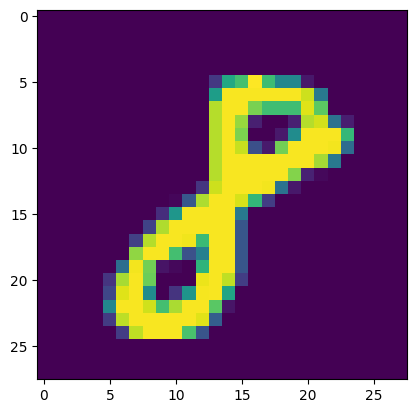

tensor([[-0.0684, -0.1266, -0.0617, -0.1549, -0.0832, -0.0190, -0.1831, -0.1336,
          0.9996, -0.1615]])
CLIP分类: 8


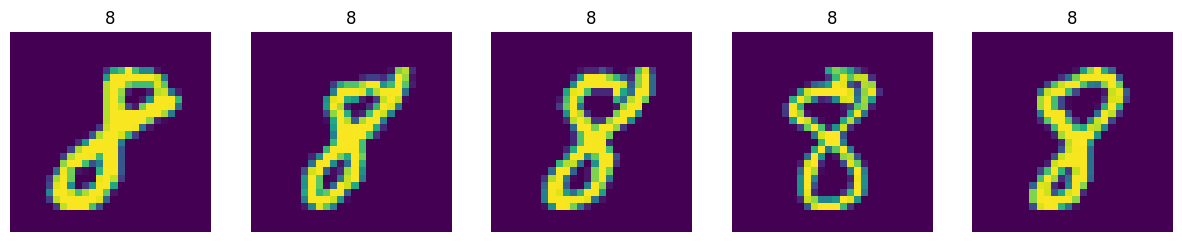

In [34]:
'''
CLIP能力演示

1、对图片做分类
2、对图片求相图片

'''

from dataset import MNIST
import matplotlib.pyplot as plt
import torch
from clip import CLIP
import torch.nn.functional as F

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'   # 设备

dataset=MNIST() # 数据集

model=CLIP().to(DEVICE) # 模型
model.load_state_dict(torch.load('model.pth'))

model.eval()    # 预测模式

'''
1、对图片分类
'''
image,label=dataset[0]
print('正确分类:',label)
plt.imshow(image.permute(1,2,0))
plt.show()


### TODO: TASK 3: 完成CLIP模型进行预测的代码 (BEGIN)

with torch.no_grad():
    # 为每个数字(0-9)生成文本嵌入
    all_text_embeddings = model.text_enc(torch.arange(10).to(DEVICE))
    # 获取图像嵌入
    image_embedding = model.img_enc(image.unsqueeze(0).to(DEVICE))

    # 规范化嵌入
    image_embedding = image_embedding / image_embedding.norm(dim=1, keepdim=True)
    all_text_embeddings = all_text_embeddings / all_text_embeddings.norm(dim=1, keepdim=True)

    # 计算相似度
    similarity = torch.mm(image_embedding, all_text_embeddings.t())
    print(similarity)

    # 选择相似度最高的作为预测结果
    predicted_label = similarity.argmax(dim=1).item()

### TODO: TASK 3: 完成CLIP模型进行预测的代码 (END)

print('CLIP分类:', predicted_label)

'''
2、图像相似度
'''
other_images=[]
other_labels=[]
for i in range(1,101):
    other_image,other_label=dataset[i]
    other_images.append(other_image)
    other_labels.append(other_label)

### TODO: TASK 4: 使用CLIP的image encoder，从other_images里检索和image最相似的5张图像 (BEGIN)

with torch.no_grad():
    # 将其他图像转换为张量
    other_images_tensor = torch.stack(other_images).to(DEVICE)

    # 使用图像编码器获取图像嵌入
    query_embedding = model.img_enc(image.unsqueeze(0).to(DEVICE))
    other_embeddings = model.img_enc(other_images_tensor)

    # 规范化嵌入
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    other_embeddings = other_embeddings / other_embeddings.norm(dim=1, keepdim=True)

    # 计算相似度
    similarities = torch.mm(query_embedding, other_embeddings.t())

    # 获取相似度最高的5个索引
    indexs = similarities[0].topk(5).indices.cpu().numpy().tolist()

### TODO: TASK 4: 使用CLIP的image encoder，从other_images里检索和image最相似的5张图像 (END)

plt.figure(figsize=(15,15))
for i,img_idx in enumerate(indexs):
    plt.subplot(1,5,i+1)
    plt.imshow(other_images[img_idx].permute(1,2,0))
    plt.title(other_labels[img_idx])
    plt.axis('off')
plt.savefig(f"output/similarity{label}.pdf")
plt.show()